# Assignment 2: recommender System

## Code from the lecture

In [65]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )


In [66]:
#gerate matrix (this can be done more efficiently!)
#np.shapes(users) = generates (943,5)
#The [0] is to take the first element so 943
#Insert the data into the matrix

R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [67]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [68]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

CPU times: user 1min 16s, sys: 401 ms, total: 1min 17s
Wall time: 1min 17s


In [69]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [70]:
#EuclidianDistance Fonction
def EuclidianDist(a,b):
    #or np.sqrt(np.sum((a - b) ** 2))
    return np.linalg.norm(a-b)

In [75]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_euclid=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_euclid[i,j]=EuclidianDist(R[:,i],R[:,j])

CPU times: user 50.6 s, sys: 579 ms, total: 51.2 s
Wall time: 52 s


(array([ 18.,  43., 114., 143., 158., 156., 144., 102.,  51.,  14.]),
 array([0.   , 0.476, 0.952, 1.428, 1.904, 2.38 , 2.856, 3.332, 3.808,
        4.284, 4.76 ]),
 <BarContainer object of 10 artists>)

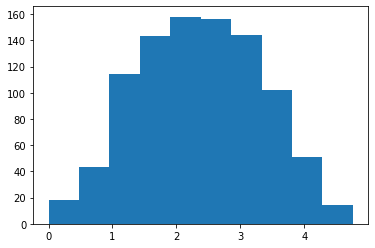

In [87]:
#Comparaison of Cosin and Euclidan method
plt.hist(test_Score(D,R)) #For Cosin method

(array([236., 129., 137., 120., 126.,  81.,  61.,  31.,  17.,   5.]),
 array([0.   , 0.484, 0.968, 1.452, 1.936, 2.42 , 2.904, 3.388, 3.872,
        4.356, 4.84 ]),
 <BarContainer object of 10 artists>)

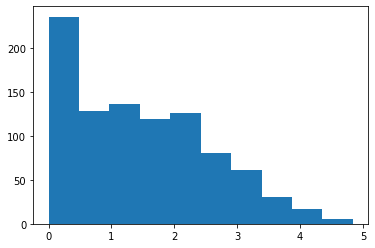

In [88]:
plt.hist(test_Score(D_euclid,R)) #For the distance Euclid method

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [72]:
#Fonction Random recommendations
def randomRecommendations(amount):
    
    #Generate Random ID-Movies 
    Array_Movies_ID=np.random.randint(np.shape(movies)[0],size=amount)
    print("These random films could be great !")
    
    return getNameByID(Array_Movies_ID)
    
randomRecommendations(5)

These random films could be great !


592                                   Stalingrad (1993)
278     Once Upon a Time... When We Were Colored (1995)
1410                                  Barbarella (1968)
82                        Much Ado About Nothing (1993)
1458                            Madame Butterfly (1995)
Name: title, dtype: object

In [73]:
#Always recommending the top 5 movies
def alwaysRecommand(amount):

    array_Average = np.mean(R, axis=0) # We take the average of rate for each movie
    films_ID = np.arange(0 ,np.shape(movies)[0]+1,1)

    P = array_Average.argsort() # We sort the array of average first

    fiveFirstFilms_ID = films_ID[P][-amount:][::-1] # Then we sort the array of Movies according to the average rate
    
    print("Top 5 Movies of all users")
    return getNameByID(fiveFirstFilms_ID)

alwaysRecommand(5)

Top 5 Movies of all users


49                   Star Wars (1977)
99                       Fargo (1996)
180         Return of the Jedi (1983)
257                    Contact (1997)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


(1682, 1682)
(1682,)
(1682, 1682)


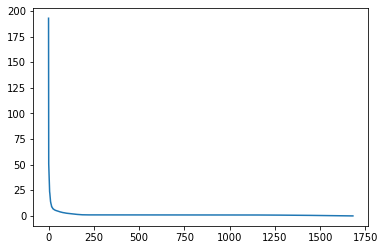

In [131]:
u,s,vh = np.linalg.svd(D)
print(u.shape)
print(s.shape)
print(vh.shape)

reconst = np.matrix(u[:, :100]) * np.diag(s[:100]) * np.matrix(vh[:100, :])
plt.plot(s)

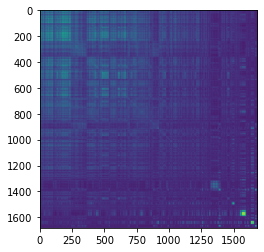

In [123]:
#SVD Reconstruct for s = 100
plt.imshow(reconst)

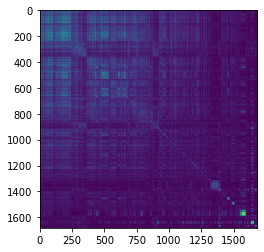

In [124]:
#plt Cosine Method
plt.imshow(D)

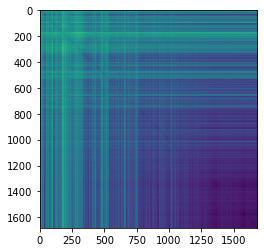

In [125]:
#PLT Distance_euclidian
plt.imshow(D_euclid)

(array([ 30.,  64., 116., 116., 126., 144., 139., 116.,  78.,  14.]),
 array([0.96 , 1.352, 1.744, 2.136, 2.528, 2.92 , 3.312, 3.704, 4.096,
        4.488, 4.88 ]),
 <BarContainer object of 10 artists>)

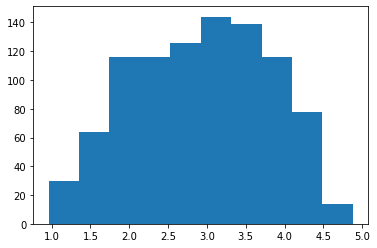

In [132]:
# We test the SVD method
AB=np.where(reconst < 0,np.abs(reconst),reconst) 
plt.hist(test_Score(AB,R))